In [122]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import math
import matplotlib.pyplot as plt
import statsmodels.datasets as ds
%matplotlib inline

心臓移植後の生存率データ入手
survivalは生存日数，censorは観察が完了したかどうかを示す

In [123]:
dt = ds.heart.load_pandas().data
dt.tail()

,survival,censors,age
64,14,1,40.3
65,167,0,26.7
66,110,0,23.7
67,13,0,28.9
68,1,0,35.2


生存日数が保存されているデータのみ抽出する

In [124]:
dt = dt[dt.censors == 1]
days = dt.survival
days.tail()

57     50
59     68
60     26
63    161
64     14
Name: survival, dtype: float64

ソートして表示

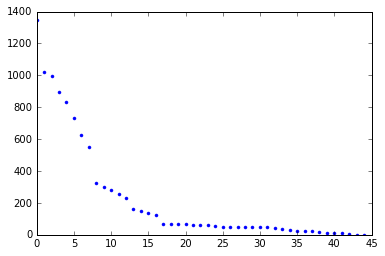

In [125]:
plt.plot(sorted(days)[::-1], '.')

ヒストグラム表示

(array([ 12.,  16.,   0.,   3.,   1.,   1.,   1.,   2.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.]),
 array([  1.00000000e+00,   3.95428571e+01,   7.80857143e+01,
          1.16628571e+02,   1.55171429e+02,   1.93714286e+02,
          2.32257143e+02,   2.70800000e+02,   3.09342857e+02,
          3.47885714e+02,   3.86428571e+02,   4.24971429e+02,
          4.63514286e+02,   5.02057143e+02,   5.40600000e+02,
          5.79142857e+02,   6.17685714e+02,   6.56228571e+02,
          6.94771429e+02,   7.33314286e+02,   7.71857143e+02,
          8.10400000e+02,   8.48942857e+02,   8.87485714e+02,
          9.26028571e+02,   9.64571429e+02,   1.00311429e+03,
          1.04165714e+03,   1.08020000e+03,   1.11874286e+03,
          1.15728571e+03,   1.19582857e+03,   1.23437143e+03,
          1.27291429e+03,   1.31145714e+03,   1.35000000e+03]),
 <a list o

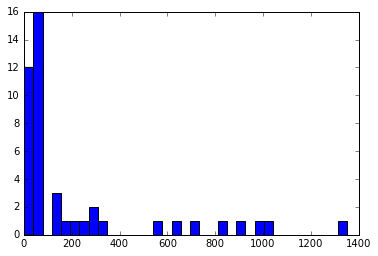

In [126]:
bins = 35
plt.hist(days, bins=bins)

指数関数で当てはめてみる
指数関数の最尤関数は
$$L(\lambda, \{s_i\}) = P(\{s_i\}|\lambda) = \lambda^n \exp(-\lambda n \bar{s})$$
と，なり
最大になるのは
$$\frac{\partial L}{\partial \lambda} = n\lambda^{n-1}\exp(-\lambda n \bar{s}) - n\bar{s}\lambda^{n} \exp(-\lambda n \bar{s}) = 0$$
$$n^{-1}\exp(\lambda n \bar{s})\frac{\partial L}{\partial \lambda} = \lambda^{n-1} - \bar{s}\lambda^{n} = 0$$
より
$$\lambda = \frac{1}{\bar{s}}$$

In [127]:
lmbd = 1.0 / days.mean()
interval = np.linspace(0.0, days.max(), 1000)
dt = interval / 999.0
dist_exp = stats.expon.pdf(interval, scale = days.mean())

ここでdist_expは
$$P(x(=interval)) = \frac{1}{\bar{s}}\exp(-\bar{s}^{-1}[interval])$$であり，最尤推定から求めた確率密度関数である．
ヒストグラムは
$$n * P(x) * max /スパン$$で求まるので，

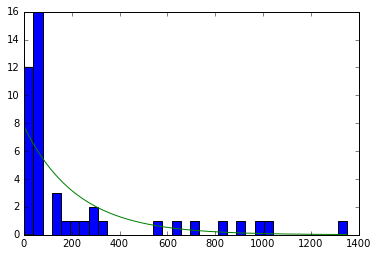

In [128]:
plt.hist(days, bins)
plt.plot(interval, dist_exp * len(days) * days.max() / (bins))

あまりあっていないように見える
コルモゴロフ-スミルノフ検定で調べてみる

(-2.5935321915766018e-08, 96.706486229972768)
KstestResult(statistic=0.19424647101988513, pvalue=0.058114340911952)


(array([ 7.,  0.,  0.,  6.,  0.,  0.,  5.,  0.,  0.,  4.,  0.,  0.,  3.,
         0.,  0.,  3.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([   0.        ,    9.22857143,   18.45714286,   27.68571429,
          36.91428571,   46.14285714,   55.37142857,   64.6       ,
          73.82857143,   83.05714286,   92.28571429,  101.51428571,
         110.74285714,  119.97142857,  129.2       ,  138.42857143,
         147.65714286,  156.88571429,  166.11428571,  175.34285714,
         184.57142857,  193.8       ,  203.02857143,  212.25714286,
         221.48571429,  230.71428571,  239.94285714,  249.17142857,
         258.4       ,  267.62857143,  276.85714286,  286.08571429,
         295.31428571,  304.54285714,  313.77142857,  323.        ]),
 <a list of 35 Patch objects>)

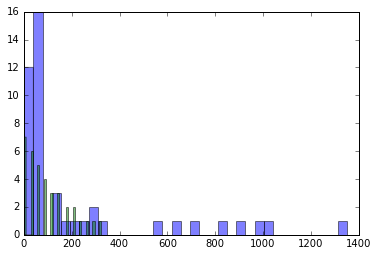

In [129]:
lh_dt1 = dist_exp * len(days) * days.max() / (bins)
interval2 = list(map(lambda n:math.floor(n / days.max() * 999), list(np.linspace(0.0, days.max(), bins))))
hist_lh_dt1 = []
for x in interval2:
    for  y in range(0, math.floor(lh_dt1[x])):
        hist_lh_dt1.append(x)

args = stats.expon.fit(hist_lh_dt1)
print(args)
print(stats.kstest(days, stats.expon.cdf, args))
plt.hist(days, bins, alpha=0.50)
plt.hist(hist_lh_dt1, bins, alpha=0.50)

一応あっているが結構ギリギリ.細かいとダメになるらしい
数値解析で求めてみる

KstestResult(statistic=0.36199685486406347, pvalue=8.6470960143358866e-06)


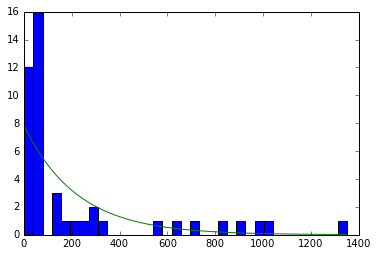

In [130]:
loc, size = stats.expon.fit(days)
dist_exp_na = stats.expon.pdf(interval, loc=loc, scale = size)
print(stats.kstest(days, stats.expon.cdf, [loc, size]))
plt.hist(days, bins)
plt.plot(interval, dist_exp_na * len(days) * days.max() / (bins))

細かいとダメになるらしい.
別の回帰方法(パーンバウム・サンダース分布)を使ってみる．
この分布は故障が発生するまでの時間をモデル化するのによく使用される．

In [131]:
bs_dist = stats.fatiguelife
args_bs = bs_dist.fit(days)
print(stats.kstest(days, bs_dist.cdf, args_bs))

KstestResult(statistic=0.18773446101946889, pvalue=0.073211497000863268)


7%なのでまともそうである．プロットしてみる

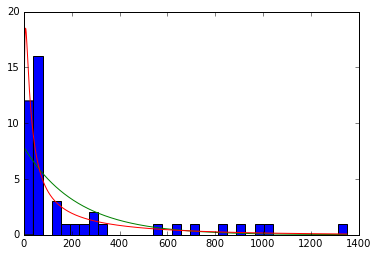

In [132]:
bs_pdf = bs_dist.pdf(interval, *args_bs)
coef = len(days) * days.max() / (bins)
plt.hist(days, bins)
plt.plot(interval, coef * dist_exp_na)
plt.plot(interval, coef * bs_pdf)

確かに近いことがわかる